In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset

data = load_dataset("monash_tsf", "solar_weekly")

Reusing dataset monash_tsf (/home/clement/.cache/huggingface/datasets/monash_tsf/solar_weekly/1.0.0/82998723d55d6edbc664cfaebe371004d849846ee5f61b57f1f974000d44c050)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Preprocess data
import torch

train_data = torch.tensor(data['train']['target'])
eval_data  = torch.tensor(data['validation']['target'])

train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
eval_data = (eval_data - eval_data.min()) / (eval_data.max() - eval_data.min())

In [4]:
# Define custom encoder and decoder
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_utils import ModelOutput
import torch.nn as nn
import torch
import numpy as np

class EncoderLSTM(BaseEncoder):

    def __init__(self, model_config: dict):
        BaseEncoder.__init__(self)
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=4)
        
        self.mu = nn.Linear(256, model_config.latent_dim)
        self.log_var = nn.Linear(256, model_config.latent_dim)

    def forward(self, x):
        h = self.lstm(x)[0][:, -1, :]

        return ModelOutput(
            embedding=self.mu(h).squeeze(1),
            log_covariance=self.log_var(h).squeeze(1)
        )

class DecoderLSTM(BaseDecoder):

    def __init__(self, model_config: dict):
        BaseDecoder.__init__(self)
        self.dense = nn.Sequential(
            nn.Linear(model_config.latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, np.prod(model_config.input_dim)),
            nn.Sigmoid()
        )

    def forward(self, z):    
        return ModelOutput(
            reconstruction=self.dense(z)
        )
       

In [5]:
# Build model
from pythae.models import VAE, VAEConfig
model_config = VAEConfig(input_dim=(42,1), latent_dim=8)

encoder_lstm = EncoderLSTM(model_config=model_config)
decoder_lstm = DecoderLSTM(model_config=model_config)

model = VAE(
    model_config=model_config,
    encoder=encoder_lstm,
    decoder=decoder_lstm
)

In [6]:
# Define training config
from pythae.trainers import BaseTrainerConfig

training_config = BaseTrainerConfig(
    num_epochs=50,
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    output_dir='my_lstm_models'
)

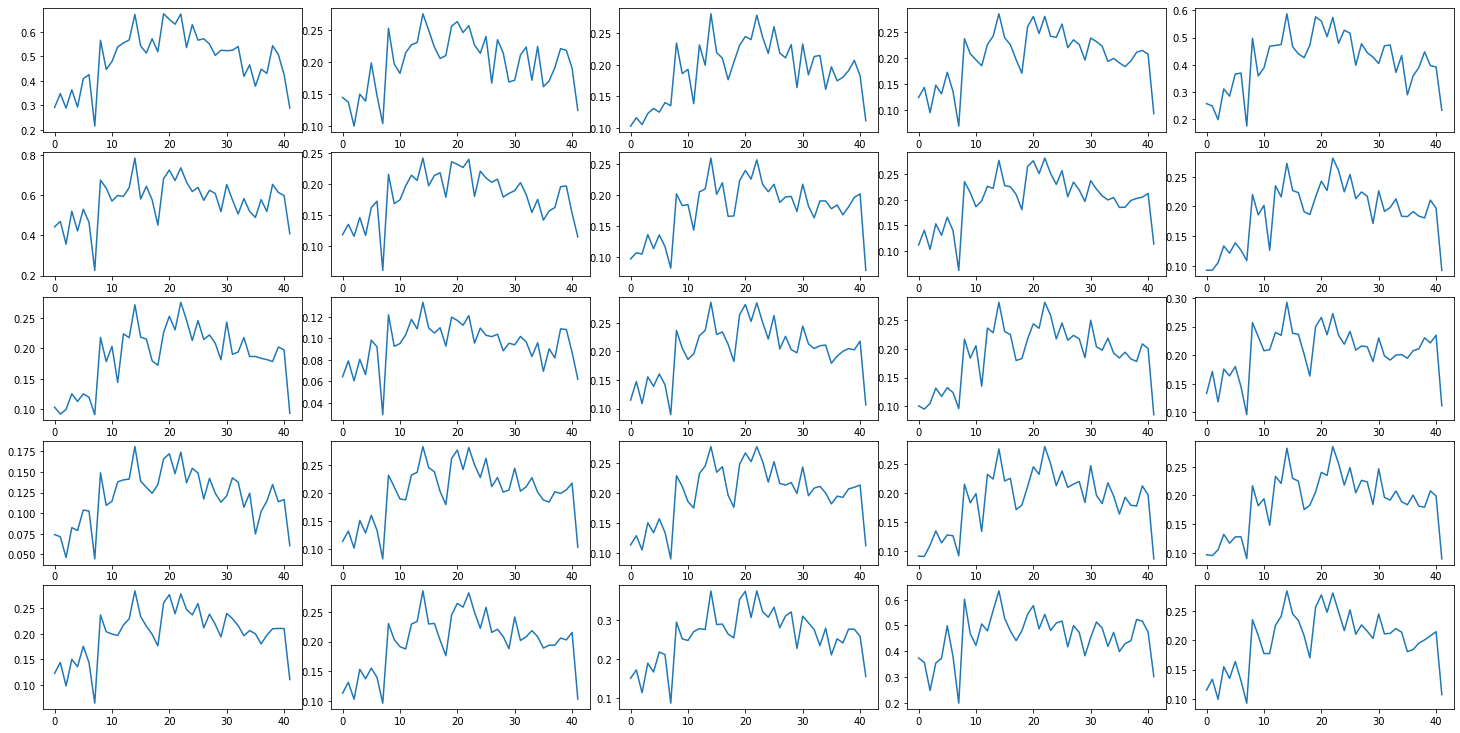

In [7]:
# Visualize data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].plot(train_data[i*5 +j].cpu())
plt.tight_layout(pad=0.)

In [8]:
# Train model
from pythae.pipelines import TrainingPipeline

pipeline = TrainingPipeline(
    model=model,
    training_config=training_config
)

pipeline(
    train_data=train_data.unsqueeze(-1),
    eval_data=eval_data.unsqueeze(-1)[:, :42] # only keep 42th first example since this is a time-serie forcasting dataset
)

Preprocessing train data...
Preprocessing eval data...

Using Base Trainer

Model passed sanity check !

Created my_lstm_models/VAE_training_2022-08-24_11-20-11. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 1/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.9969
Eval loss: 4.2797
--------------------------------------------------------------------------


Training of epoch 2/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 2/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 4.1318
Eval loss: 4.1712
--------------------------------------------------------------------------


Training of epoch 3/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 3/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.8264
Eval loss: 4.094
--------------------------------------------------------------------------


Training of epoch 4/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 4/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.7531
Eval loss: 3.9552
--------------------------------------------------------------------------


Training of epoch 5/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 5/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.7352
Eval loss: 3.8903
--------------------------------------------------------------------------


Training of epoch 6/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 6/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.5547
Eval loss: 3.7199
--------------------------------------------------------------------------


Training of epoch 7/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 7/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.5296
Eval loss: 3.6323
--------------------------------------------------------------------------


Training of epoch 8/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 8/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.5749
Eval loss: 3.5484
--------------------------------------------------------------------------


Training of epoch 9/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 9/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1858
Eval loss: 3.4212
--------------------------------------------------------------------------


Training of epoch 10/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 10/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2487
Eval loss: 3.3403
--------------------------------------------------------------------------


Training of epoch 11/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 11/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0834
Eval loss: 3.2566
--------------------------------------------------------------------------


Training of epoch 12/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 12/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.16
Eval loss: 3.2149
--------------------------------------------------------------------------


Training of epoch 13/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 13/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9151
Eval loss: 3.0684
--------------------------------------------------------------------------


Training of epoch 14/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 14/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8633
Eval loss: 2.9777
--------------------------------------------------------------------------


Training of epoch 15/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 15/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7511
Eval loss: 2.9537
--------------------------------------------------------------------------


Training of epoch 16/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 16/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6475
Eval loss: 2.7862
--------------------------------------------------------------------------


Training of epoch 17/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 17/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8127
Eval loss: 2.7119
--------------------------------------------------------------------------


Training of epoch 18/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 18/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6038
Eval loss: 2.5977
--------------------------------------------------------------------------


Training of epoch 19/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 19/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5188
Eval loss: 2.5765
--------------------------------------------------------------------------


Training of epoch 20/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 20/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2927
Eval loss: 2.61
--------------------------------------------------------------------------


Training of epoch 21/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 21/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4198
Eval loss: 2.4855
--------------------------------------------------------------------------


Training of epoch 22/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 22/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3732
Eval loss: 2.4925
--------------------------------------------------------------------------


Training of epoch 23/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 23/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2706
Eval loss: 2.3046
--------------------------------------------------------------------------


Training of epoch 24/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 24/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2004
Eval loss: 2.2145
--------------------------------------------------------------------------


Training of epoch 25/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 25/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3243
Eval loss: 2.2502
--------------------------------------------------------------------------


Training of epoch 26/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 26/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.0091
Eval loss: 2.1245
--------------------------------------------------------------------------


Training of epoch 27/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 27/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.0281
Eval loss: 2.0826
--------------------------------------------------------------------------


Training of epoch 28/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 28/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.8591
Eval loss: 1.9723
--------------------------------------------------------------------------


Training of epoch 29/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 29/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.8325
Eval loss: 1.8889
--------------------------------------------------------------------------


Training of epoch 30/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 30/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1091
Eval loss: 1.8318
--------------------------------------------------------------------------


Training of epoch 31/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 31/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.9102
Eval loss: 1.9429
--------------------------------------------------------------------------


Training of epoch 32/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 32/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.7738
Eval loss: 1.9008
--------------------------------------------------------------------------


Training of epoch 33/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 33/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.784
Eval loss: 1.7678
--------------------------------------------------------------------------


Training of epoch 34/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 34/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.6706
Eval loss: 1.6629
--------------------------------------------------------------------------


Training of epoch 35/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 35/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.6326
Eval loss: 1.6723
--------------------------------------------------------------------------


Training of epoch 36/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 36/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.4652
Eval loss: 1.6317
--------------------------------------------------------------------------


Training of epoch 37/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 37/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.5836
Eval loss: 1.6081
--------------------------------------------------------------------------


Training of epoch 38/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 38/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.4958
Eval loss: 1.5453
--------------------------------------------------------------------------


Training of epoch 39/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 39/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.4372
Eval loss: 1.4437
--------------------------------------------------------------------------


Training of epoch 40/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 40/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.4578
Eval loss: 1.4041
--------------------------------------------------------------------------


Training of epoch 41/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 41/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.3897
Eval loss: 1.3758
--------------------------------------------------------------------------


Training of epoch 42/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 42/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.3093
Eval loss: 1.3748
--------------------------------------------------------------------------


Training of epoch 43/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 43/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.3196
Eval loss: 1.3754
--------------------------------------------------------------------------


Training of epoch 44/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 44/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.2773
Eval loss: 1.3069
--------------------------------------------------------------------------


Training of epoch 45/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 45/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.3177
Eval loss: 1.2582
--------------------------------------------------------------------------


Training of epoch 46/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 46/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.1695
Eval loss: 1.2408
--------------------------------------------------------------------------


Training of epoch 47/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 47/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.247
Eval loss: 1.2796
--------------------------------------------------------------------------


Training of epoch 48/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 48/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.1773
Eval loss: 1.1581
--------------------------------------------------------------------------


Training of epoch 49/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 49/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.1176
Eval loss: 1.1483
--------------------------------------------------------------------------


Training of epoch 50/50:   0%|          | 0/3 [00:00<?, ?batch/s]

Eval of epoch 50/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1.0096
Eval loss: 1.0836
--------------------------------------------------------------------------
Training ended!
Saved final model in my_lstm_models/VAE_training_2022-08-24_11-20-11/final_model


In [9]:
# Reload model
import os
from pythae.models import AutoModel

last_training = sorted(os.listdir('my_lstm_models'))[-1]
trained_model = AutoModel.load_from_folder(os.path.join('my_lstm_models', last_training, 'final_model'))

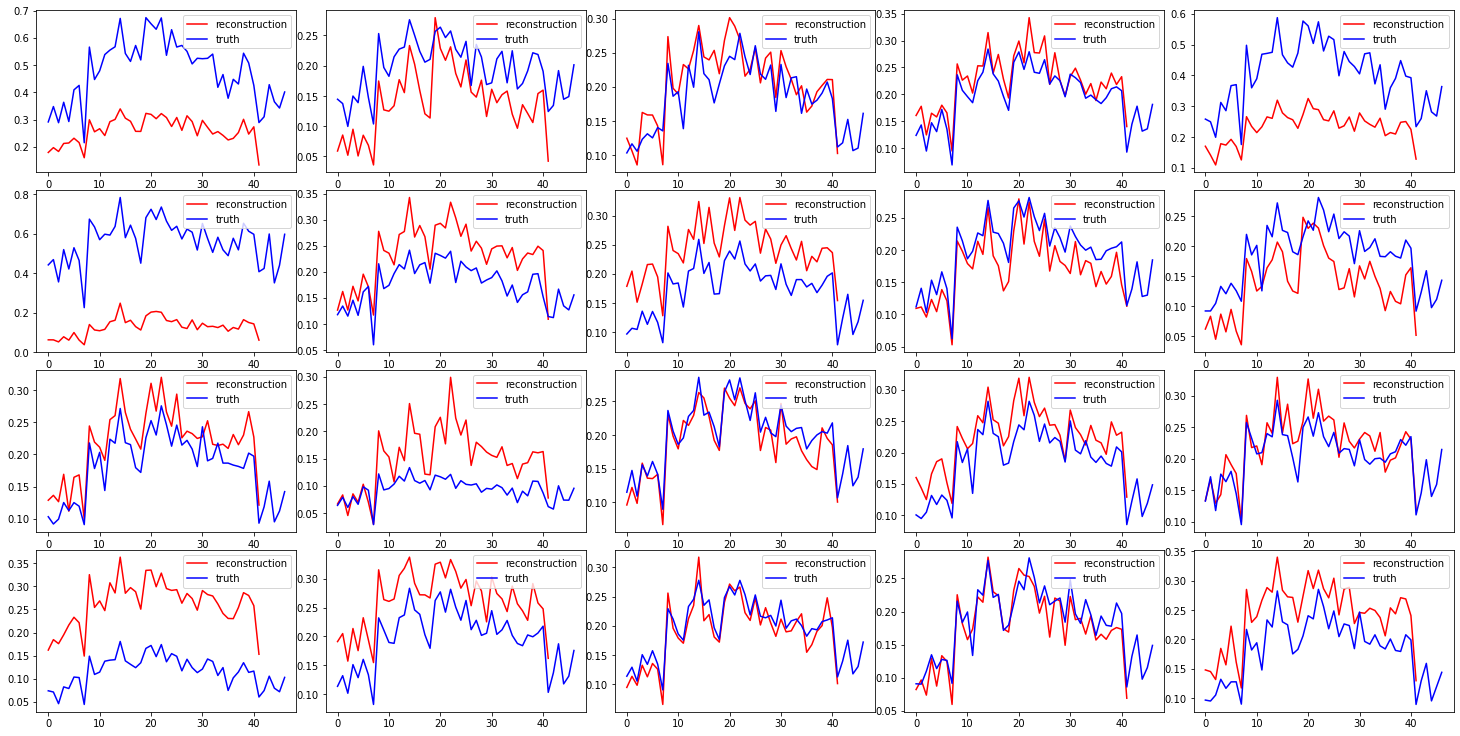

In [ ]:
# show reconstructions
reconstructions = model.reconstruct(eval_data.unsqueeze(-1)[:20, :42, :].cuda()).detach().cpu()

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 10))

for i in range(4):
    for j in range(5):
        axes[i][j].plot(reconstructions[i*5 + j].cpu(), c='r', label='reconstruction')
        axes[i][j].plot(eval_data[i*5 + j].cpu(), c='blue', label='truth')

        axes[i][j].legend(loc=1)
plt.tight_layout(pad=0.)

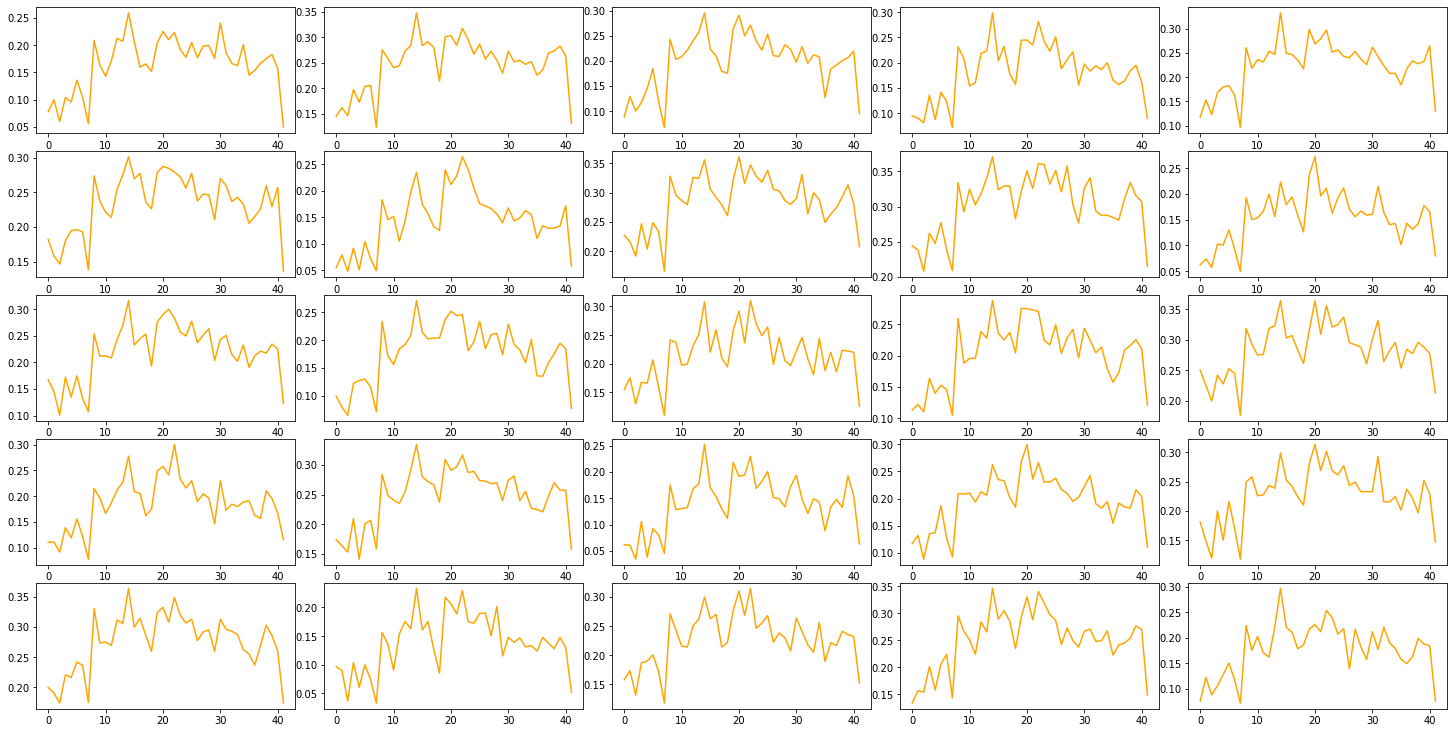

In [ ]:
# Generate time-series
from pythae.samplers import NormalSampler

# create normal sampler
normal_samper = NormalSampler(
    model=trained_model
)

# sample
gen_data = normal_samper.sample(
    num_samples=25
)

# show results with normal sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].plot(gen_data[i*5 +j].cpu(), c='orange')
plt.tight_layout(pad=0.)